### Case 4B - Offshore windfarm - AC Substation - AC Collection cable
This notebook shows the basics of Case 4b as suggested by Noor Abrahamse:

#### 0. Import basic methods (a.o. from source2.py)

In [1]:
from source2 import *
import folium
import numpy as np
import matplotlib.pyplot as plt

import pyproj
import shapely.geometry
from shapely.geometry.base import BaseGeometry

In [2]:
import matplotlib.pyplot as plt
from scipy import stats 

In [3]:
# load basic info from the Input sheet
mapping = load_input_from_xls(filename=r'H2 Model - Input sheet (4B).xlsm')
Inputs = extract_scenario(mapping, 'Scenario1')

##### 1. prepare input data and generate objects

In [4]:
foundation_data = get_object_data(Inputs=Inputs, 
                               subsystem='Wind energy source & Transport', 
                               element='Offshore wind park',
                               component='Foundation & cable')
foundation_data['depreciation_rate']=1/foundation_data['economic_lifetime']

turbine_data = get_object_data(Inputs=Inputs, 
                               subsystem='Wind energy source & Transport', 
                               element='Offshore wind park',
                               component='Turbine')
turbine_data['depreciation_rate']=1/turbine_data['economic_lifetime']

AC_substation_data = get_object_data(Inputs=Inputs, 
                               subsystem='AC Substation & Transport', 
                               element='AC Substation & Transport',
                               component='AC Substation')
AC_substation_data['depreciation_rate']=1/AC_substation_data['economic_lifetime']

AC_collection_cable_data = get_object_data(Inputs=Inputs, 
                               subsystem='AC Substation & Transport', 
                               element='AC Substation & Transport',
                               component='DC collection cable')
AC_collection_cable_data['depreciation_rate']=1/AC_collection_cable_data['economic_lifetime']

DCAC_converter_data = get_object_data(Inputs=Inputs, 
                               subsystem='Electrolysis, Electricity & Transport', 
                               element='Electricity',
                               component='DCAC Converter')
AC_collection_cable_data['depreciation_rate']=1/DCAC_converter_data['economic_lifetime']

Mainland_data = get_object_data(Inputs=Inputs, 
                               subsystem='Electrolysis, Electricity & Transport', 
                               element='Facility location',
                               component='Mainland')
AC_collection_cable_data['depreciation_rate']=1/Mainland_data['economic_lifetime']

issue detected


In [5]:
# Create a list of capex_per_unit's
capex_per_unit = stats.norm(turbine_data['capex_per_unit'],turbine_data['capex_per_unit']*0.1)
capex_per_unit_realisations = capex_per_unit.rvs(100)

In [6]:
total_wind_energy_production = 3000 * 1000 * 4380 * 27 # parkcapacity * operational hours * operational lifecycle
print('total_wind_energy_production: {:.0f} kWh'.format(total_wind_energy_production))
energy_after_inter_array_cable_loss = 0.98 * total_wind_energy_production
print('energy_after_inter_array_cable_loss (20 km): {:.0f} kWh'.format(energy_after_inter_array_cable_loss))
energy_after_AC_collection_cable_loss = 0.98 * energy_after_inter_array_cable_loss
print('energy_after_AC_collection_cable_loss (20 km): {:.0f} kWh'.format(energy_after_AC_collection_cable_loss))

total_wind_energy_production: 354780000000 kWh
energy_after_inter_array_cable_loss (20 km): 347684400000 kWh
energy_after_AC_collection_cable_loss (20 km): 340730712000 kWh


In [8]:
# is nog niet het snelste proces ... further optimisation needed
lifecycle = 30
LCOEs = []
for value in capex_per_unit_realisations:
    Turbine = Object(**turbine_data)
    Turbine.capex_per_unit = value
    Foundation = Object(**foundation_data)
    ACStation = Object(**AC_substation_data)
    ACCollectionCable = Object(**AC_collection_cable_data)
    DCACConverter = Object(**DCAC_converter_data)
    Mainland = Object(**Mainland_data)

    Foundation.generate_cashflows(startyear=2023, lifecycle=lifecycle, debug=False)
    Turbine.generate_cashflows(startyear=2023, lifecycle=lifecycle, debug=False)
    ACStation.generate_cashflows(startyear=2023, lifecycle=lifecycle, debug=False)
    ACCollectionCable.generate_cashflows(startyear=2023, lifecycle=lifecycle, debug=False)
    DCACConverter.generate_cashflows(startyear=2023, lifecycle=lifecycle, debug=False)
    Mainland.generate_cashflows(startyear=2023, lifecycle=lifecycle, debug=False)
    
    # collect the npv calculations per item (without revenues)
    Turbine.df_npv = calculate_npv(Turbine.df, 2023, WACC=0.0984)
    Foundation.df_npv = calculate_npv(Foundation.df, 2023, WACC=0.0984)
    ACStation.df_npv = calculate_npv(ACStation.df, 2023, WACC=0.0984)
    ACCollectionCable.df_npv = calculate_npv(ACCollectionCable.df, 2023, WACC=0.0984)
    DCACConverter.df_npv = calculate_npv(DCACConverter.df, 2023, WACC=0.0984)
    Mainland.df_npv = calculate_npv(Mainland.df, 2023, WACC=0.0984)
    
    data = [
        -Foundation.df_npv.cashflow_sum.iloc[-1],
        -Turbine.df_npv.cashflow_sum.iloc[-1],
        -ACStation.df_npv.cashflow_sum.iloc[-1],
        -ACCollectionCable.df_npv.cashflow_sum.iloc[-1],
        -DCACConverter.df_npv.cashflow_sum.iloc[-1],
        -Mainland.df_npv.cashflow_sum.iloc[-1],
    ]   
    
    total_energy = energy_after_AC_collection_cable_loss # kWh
    total_cost = sum(data)            # EU
    
    LCOEs.append(total_cost / total_energy)

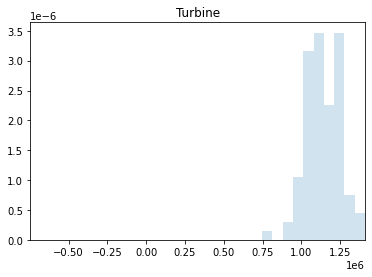

In [7]:
fig, ax = plt.subplots(1, 1)
plt.hist(capex_per_unit_realisations, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.set_xlim([round(-min(capex_per_unit_realisations)), round(max(capex_per_unit_realisations))])
ax.set_title(turbine_data['component'])
plt.show()

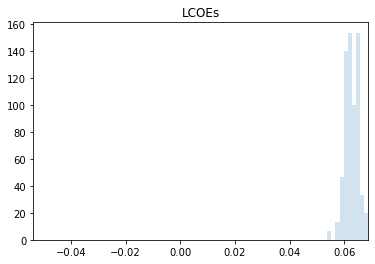

In [9]:
fig, ax = plt.subplots(1, 1)
plt.hist(LCOEs, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.set_xlim([-min(LCOEs), max(LCOEs)])
ax.set_title('LCOEs')
plt.show()